In [1]:
import numpy as np
# from sklearn.utils.extmath import softmax
from matplotlib import pyplot as plt
import re
from tqdm import trange
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from sklearn.datasets import fetch_openml

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

## Sample implementation of FFNN 

In [2]:
import random
import numpy as np

class DeepFFNN(object):
    """
    Genearal Deep Feedforward Neural Network implementation 
    Input data type: training_data = [pattern1, pattern2, ..., pattern n]
    Activation: tanh for hidden layer and sigmoid for output layer 
    
    pattern i = [np.array (input), np.array (output)]
    
    TODO: Currently uses square loss. Should be easy to implement other loss functions. 
    """
    def __init__(self, 
                 hidden_layer_sizes,  # input and output layer sizes read off from training data
                 training_data,  # list of patterns [np.array (input), np.array (output)]
                 activation_list=None): # desired list of activation functions in each layer. 
       
        # initialize training data and layer info
        self.training_data = training_data
        self.activation_list = activation_list
        self.list_layer_sizes = [len(self.training_data[0][0]) + 1] + hidden_layer_sizes + [len(self.training_data[0][1])]        
        # add hidden unit in the input layer. No hidden units for the hidden layers. 
        self.n_layers = len(self.list_layer_sizes)-1 # the total number of layers minus 1 (the training data)
        
        self.initialize()
        
    def initialize(self):
        
        # list of activation functions
        if self.activation_list is None:
            activation_list = ['tanh' for i in np.arange(len(self.list_layer_sizes))]
            activation_list[0] = 'identity'  # dummy activation for the input layer
            activation_list[-1] = 'sigmoid'
            self.activation_list = activation_list

        # default activation of nodes
        node_states = []
        for i in np.arange(len(self.list_layer_sizes)):
            node_states.append(np.zeros(shape=[self.list_layer_sizes[i], ]))
        self.node_states = node_states
        
        # initial weight matrices 
        # use scheme from 'efficient backprop to initialize weights'
        weight_matrices = []
        for i in np.arange(self.n_layers):
            weight_range = 1/(self.list_layer_sizes[i]**(0.5))
            U = np.random.normal(loc = 0, scale = weight_range, size = (self.list_layer_sizes[i], self.list_layer_sizes[i+1]))
            weight_matrices.append(U)
            print('weight_matrix.shape', U.shape)
        self.weight_matrices = weight_matrices
           
        # create arrays of 0's to store previous gradients for momentum term in SGD update 
        prev_grad_list = []
        for i in np.arange(self.n_layers):
            V = np.zeros((self.list_layer_sizes[i], self.list_layer_sizes[i+1]))
            prev_grad_list.append(V)
        self.prev_grad_list = prev_grad_list

    def forwardPropagate(self, inputs):
        # Forward propagate the input using the current weights and update node states 
        self.node_states[0][:-1] = inputs # avoid last coordinate for hidden unit 
        for i in np.arange(self.n_layers):    
            X_new = self.node_states[i].T @ self.weight_matrices[i]
            X_new = activation(X_new, type=self.activation_list[i+1])
            self.node_states[i+1] = X_new
        
        return self.node_states[-1]

    def backPropagate(self, targets):
        """
        Backpropagate errors from the output to the input layer 
        Return gradients for the weight matrices
        """
    
        error_list = self.node_states.copy()
        # error at the output layer to be backpropagated 
        error = -(np.asarray(targets) - np.asarray(self.node_states[-1]))
        for L in range(self.n_layers, 0, -1): # layer index to be backpropagated 
            # print('L', L)
            if L < self.n_layers: # Not backpropagating from the output layer
                error = self.weight_matrices[L] @ error_list[L+1].reshape(-1,1)
                error = error[:,0] 
            error_list[L] = delta_activation(self.node_states[L], type=self.activation_list[L]) * error
            
        # Compute the gradients
        grad_list = self.weight_matrices.copy()
        for i in np.arange(self.n_layers):
            grad_list[i] = self.node_states[i].reshape(-1,1) @ error_list[i+1].reshape(1,-1) 
        
        return grad_list


    def train(self, iterations=100, learning_rate=0.5, momentum=0.5, rate_decay=0.01, verbose=True):
        # N: learning rate
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.rate_decay = rate_decay
        error = 10
        i=0
        while (i<iterations) and (error>0.001):
            error = 0.0
            random.shuffle(self.training_data)
            for p in self.training_data:
                inputs = p[0]
                targets = p[1]
                self.forwardPropagate(inputs)
                grad_list = self.backPropagate(targets)
                
                for L in np.arange(self.n_layers):
                    # update the L th weight matrix connecting L th and (L+1)st layers 
                    grad = grad_list[L]
                    prev_grad = self.prev_grad_list[L]
                    self.weight_matrices[L] -= self.learning_rate * grad + self.momentum * prev_grad
                    self.prev_grad_list[L] = grad # store current gradient 
        
                error += (0.5) * np.linalg.norm(np.asarray(targets) - self.node_states[-1])**2
            
            with open('error.txt', 'a') as errorfile:
                errorfile.write(str(error) + '\n')
                errorfile.close()
                
            if (i % 5 == 0) and verbose:
                print('iteration %i, error %-.5f' % (i, error))
            # learning rate decay
            self.learning_rate = 1/(np.log(i+2) * (i+50)**(0.5))
            # self.learning_rate = self.learning_rate * (self.learning_rate / (self.learning_rate + (self.learning_rate * self.rate_decay)))
            
            i += 1  
        
    
    def predict(self, X, normalize = False):
        X = np.asarray(X).T
        x = np.vstack((np.asarray(X), np.ones(X.shape[1]))) # add 1 for hidden units in the input layer
        print('X.shape', X.shape)
    
        for i in np.arange(self.n_layers):    
            x = x.T @ self.weight_matrices[i]
            x = activation(x.T, type=self.activation_list[i+1])
            
        print('y_hat.shape', x.shape)
        return x
    
### Helper functions     
    
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# derivative of sigmoid
def dsigmoid(y):
    return y * (1.0 - y)

# using tanh over logistic sigmoid is recommended   

def tanh(x):
    return (1-np.exp(-2*x))/(1+np.exp(-2*x))
    # return np.tanh(x)
    
# derivative for tanh sigmoid
def dtanh(y):
    return 1 - y*y


### Helper functions

def loss_function(y, y_hat, type='cross-entropy'):
    """
    y_hat = column array of predictive PMF 
    y = column array of one-hot encoding of true class label
    """
    if type == 'cross_entropy':
        return cross_entropy(y=y, y_hat=y_hat)
    elif type == 'square':
        return (1/2) * (y_hat - y).T @ (y_hat - y)
    elif type == 'softmax-cross-entropy':
        return cross_entropy(y=y, y_hat=softmax(y_hat))
   

def delta_loss_function(y, y_hat, type='cross-entropy'):
    """
    y_hat = column array of predictive PMF 
    y = column array of one-hot encoding of true class label
    """
    # return delta_cross_entropy(y=y, y_hat=y_hat/np.sum(y_hat))
    
    if type == 'cross-entropy':
        return delta_cross_entropy(y=y, y_hat=y_hat)
    elif type == 'square':
        return y_hat - y
    elif type == 'softmax-cross-entropy':
        return softmax(y_hat) - y

        
def activation(x, type='sigmoid'):
    if type == 'sigmoid':
        return 1/(1+np.exp(-x))
    elif type == 'ReLU':
        return np.maximum(0,x)
    elif type == 'tanh':
        return tanh(x)
    elif type == 'identity':
        return x
    
def delta_activation(y, type='sigmoid'):
    # derivate of activation function
    if type == 'sigmoid':
        return y*(1-y)
    elif type == 'ReLU':
        return int((y>0))
    elif type == 'tanh':
        return 1-y**2
    elif type == 'identity':
        return 1
        
def sigmoid(x):
    return 1/(1+np.exp(-x))

def ReLU(x):
    return np.maximum(0,x)


def softmax(x):
    exps = np.exp(x - np.max(x))
    return exps / np.sum(exps)

def cross_entropy(y, y_hat):
    """
    y_hat = column array of predictive PMF 
    y = column array of one-hot encoding of true class label
    """
    return -(y.T @ np.log(y_hat))[0][0]

def delta_cross_entropy(y, y_hat):
    """
    y_hat = column array of predictive PMF 
    y = column array of one-hot encoding of true class label
    """
    y_hat /= np.max(y_hat)
    z = y.copy()
    for i in np.arange(y.shape[0]):
        a = y.argmax(axis=0)[0]
        z[i,0] = -1/y_hat[a, 0]
    return z

## Classifying MNIST images using FFNN

In [3]:
def list2onehot(y, list_classes):
    """
    y = list of class lables of length n
    output = n x k array, i th row = one-hot encoding of y[i] (e.g., [0,0,1,0,0])
    """
    Y = np.zeros(shape = [len(y), len(list_classes)], dtype=int)
    for i in np.arange(Y.shape[0]):
        for j in np.arange(len(list_classes)):
            if y[i] == list_classes[j]:
                Y[i,j] = 1
    return Y

def onehot2list(y, list_classes=None):
    """
    y = n x k array, i th row = one-hot encoding of y[i] (e.g., [0,0,1,0,0])
    output =  list of class lables of length n
    """
    if list_classes is None:
        list_classes = np.arange(y.shape[1])
        
    y_list = []
    for i in np.arange(y.shape[0]):
        idx = np.where(y[i,:]==1)
        idx = idx[0][0]
        y_list.append(list_classes[idx])
    return y_list

In [4]:
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values  ### Uncomment this line if you are having type errors in plotting. It is loading as a pandas dataframe, but our indexing is for numpy array. 
X = X / 255.

print('X.shape', X.shape)
print('y.shape', y.shape)

'''
Each row of X is a vectroization of an image of 28 x 28 = 784 pixels.  
The corresponding row of y holds the true class label from {0,1, .. , 9}.
'''

X.shape (70000, 784)
y.shape (70000,)


'\nEach row of X is a vectroization of an image of 28 x 28 = 784 pixels.  \nThe corresponding row of y holds the true class label from {0,1, .. , 9}.\n'

In [9]:
def sample_multiclass_MNIST(list_digits=['0','1', '2'], full_MNIST=None):
    # get train and test set from MNIST of given digits
    # e.g., list_digits = ['0', '1', '2']
    if full_MNIST is not None:
        X, y = full_MNIST
    else:
        X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
        X = X / 255.
    Y = list2onehot(y.tolist(), list_digits)
    
    idx = [i for i in np.arange(len(y)) if y[i] in list_digits] # list of indices where the label y is in list_digits
    
    X01 = X[idx,:]
    y01 = Y[idx,:]

    X_train = []
    X_test = []
    y_test = [] # list of one-hot encodings (indicator vectors) of each label  
    y_train = [] # list of one-hot encodings (indicator vectors) of each label  

    for i in trange(X01.shape[0]):
        # for each example i, make it into train set with probabiliy 0.8 and into test set otherwise 
        U = np.random.rand() # Uniform([0,1]) variable
        if U<0.8:
            X_train.append(X01[i,:])
            y_train.append(y01[i,:].copy())
        else:
            X_test.append(X01[i,:])
            y_test.append(y01[i,:].copy())

    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)
    return X_train, X_test, y_train, y_test


In [6]:
def compute_accuracy_metrics(Y_test, P_pred, use_opt_threshold=False, verbose=True):
    
    # y_test = binary label 
    # P_pred = predicted probability for y_test
    # compuate various binary classification accuracy metrics
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, P_pred, pos_label=None)
    mythre = thresholds[np.argmax(tpr - fpr)]
    myauc = metrics.auc(fpr, tpr)
    # print('!!! auc', myauc)
    
    # Compute classification statistics
    threshold = 0.5
    if use_opt_threshold:
        threshold = mythre
    
    Y_pred = P_pred.copy()
    Y_pred[Y_pred < threshold] = 0
    Y_pred[Y_pred >= threshold] = 1

    mcm = confusion_matrix(Y_test, Y_pred)
    
    tn = mcm[0, 0]
    tp = mcm[1, 1]
    fn = mcm[1, 0]
    fp = mcm[0, 1]

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tn / (tn + fp)
    specificity = tp / (tp + fn)
    precision = tp / (tp + fp)
    fall_out = fp / (fp + tn)
    miss_rate = fn / (fn + tp)

    # Save results
    results_dict = {}
    results_dict.update({'Y_test': Y_test})
    results_dict.update({'Y_pred': Y_pred})
    results_dict.update({'AUC': myauc})
    results_dict.update({'Opt_threshold': mythre})
    results_dict.update({'Accuracy': accuracy})
    results_dict.update({'Sensitivity': sensitivity})
    results_dict.update({'Specificity': specificity})
    results_dict.update({'Precision': precision})
    results_dict.update({'Fall_out': fall_out})
    results_dict.update({'Miss_rate': miss_rate})
    results_dict.update({'Confusion_mx': mcm})
    
    
    if verbose:
        for key in [key for key in results_dict.keys()]:
            if key not in ['Y_test', 'Y_pred', 'Confusion_mx']:
                print('% s ===> %.3f' % (key, results_dict.get(key)))
        print('Confusion matrix  ===> \n', mcm)
            
    return results_dict

In [7]:
def multiclass_accuracy_metrics(Y_test, P_pred, class_labels=None, use_opt_threshold=False):
    # y_test = multiclass one-hot encoding  labels [samples x labels]
    # Q = predicted probability for y_test
    # compuate various classification accuracy metrics
    results_dict = {}
    y_test = []
    y_pred = []
    for i in np.arange(Y_test.shape[0]):
        for j in np.arange(Y_test.shape[1]):
            if Y_test[i,j] == 1:
                y_test.append(j)
            if P_pred[i,j] == np.max(P_pred[i,:]):
                # print('!!!', np.where(P_pred[i,:]==np.max(P_pred[i,:])))
                y_pred.append(j)
            
    confusion_mx = metrics.confusion_matrix(y_test, y_pred)
    results_dict.update({'confusion_mx':confusion_mx})
    results_dict.update({'Accuracy':np.trace(confusion_mx)/np.sum(np.sum(confusion_mx))})
    print('!!! confusion_mx', confusion_mx)
    print('!!! Accuracy', results_dict.get('Accuracy'))
    
    
    return results_dict

In [10]:
# Simple MNIST binary classification experiments 

X_train, X_test, y_train, y_test = sample_multiclass_MNIST(list_digits=['0','1'], full_MNIST=[X,y])
3
# data subsampling 
train_size = 100

idx = np.random.choice(np.arange(len(y_train)), train_size)
X_train0 = X_train[idx, :]/np.max(X_train)
y_train0 = y_train[idx, :]

# preprocessing 
out = []
# populate the tuple list with the data
for i in range(X_train0.shape[0]):
    item = list((X_train0[i,:], y_train0[i,:])) 
    out.append(item)
    
    

# FFNN training
NN = DeepFFNN(hidden_layer_sizes=[], training_data = out)
NN.train(iterations=100, learning_rate = 0.5, momentum = 0, rate_decay = 0.01)


#NN = MLP_NeuralNetwork_fast(hidden=M, training_data = out)
#NN.train(iterations=100, learning_rate = 0.5, momentum = 0, rate_decay = 0.01)

# FFNN prediction

X_test /= np.max(X_test)
out_test = []
for i in range(X_test.shape[0]):
    out_test.append(X_test[i,:].tolist())

y_hat = NN.predict(out_test).T

y_test_label = np.asarray(onehot2list(y_test))
P_pred = np.asarray([p[1] for p in y_hat])

compute_accuracy_metrics(Y_test=y_test_label, P_pred=P_pred, use_opt_threshold=False, verbose=True)


100%|██████████| 14780/14780 [00:00<00:00, 373694.54it/s]


weight_matrix.shape (785, 2)
iteration 0, error 1.39793
iteration 5, error 0.07200
iteration 10, error 0.05715
iteration 15, error 0.04947
iteration 20, error 0.04442
iteration 25, error 0.04074
iteration 30, error 0.03789
iteration 35, error 0.03560
iteration 40, error 0.03371
iteration 45, error 0.03210
iteration 50, error 0.03072
iteration 55, error 0.02951
iteration 60, error 0.02845
iteration 65, error 0.02750
iteration 70, error 0.02665
iteration 75, error 0.02587
iteration 80, error 0.02517
iteration 85, error 0.02452
iteration 90, error 0.02393
iteration 95, error 0.02338
X.shape (784, 2878)
y_hat.shape (2, 2878)
AUC ===> 1.000
Opt_threshold ===> 0.643
Accuracy ===> 0.995
Sensitivity ===> 0.992
Specificity ===> 0.999
Precision ===> 0.993
Fall_out ===> 0.008
Miss_rate ===> 0.001
Confusion matrix  ===> 
 [[1292   11]
 [   2 1573]]


{'Y_test': array([1, 1, 1, ..., 1, 1, 1], shape=(2878,)),
 'Y_pred': array([1., 1., 1., ..., 1., 1., 1.], shape=(2878,)),
 'AUC': 0.9996852197005689,
 'Opt_threshold': np.float64(0.6434986703444462),
 'Accuracy': np.float64(0.9954829742876998),
 'Sensitivity': np.float64(0.9915579432079816),
 'Specificity': np.float64(0.9987301587301587),
 'Precision': np.float64(0.9930555555555556),
 'Fall_out': np.float64(0.00844205679201842),
 'Miss_rate': np.float64(0.0012698412698412698),
 'Confusion_mx': array([[1292,   11],
        [   2, 1573]])}

100%|██████████| 35735/35735 [00:00<00:00, 108590.98it/s]


weight_matrix.shape (785, 2)
weight_matrix.shape (2, 5)
iteration 0, error 5.91179
iteration 5, error 4.02157
iteration 10, error 3.73335
iteration 15, error 3.57962
iteration 20, error 3.47778
iteration 25, error 3.40354
iteration 30, error 3.34591
iteration 35, error 3.29959
iteration 40, error 3.26100
iteration 45, error 3.22803
iteration 50, error 3.19918
iteration 55, error 3.17370
iteration 60, error 3.15092
iteration 65, error 3.13047
iteration 70, error 3.11210
iteration 75, error 3.09546
iteration 80, error 3.08023
iteration 85, error 3.06620
iteration 90, error 3.05315
iteration 95, error 3.04086

X.shape (784, 10)
y_hat.shape (5, 10)
X.shape (784, 7161)
y_hat.shape (5, 7161)
!!! confusion_mx [[0 1 0 0 0]
 [0 3 0 0 0]
 [0 1 0 0 0]
 [0 3 0 0 0]
 [0 0 0 0 2]]
!!! Accuracy 0.5
!!! confusion_mx [[   0 1161    0    0  243]
 [   0 1534    0    0   19]
 [   0  896    0    0  533]
 [   0 1199    0    0  208]
 [   0   75    0    0 1293]]
!!! Accuracy 0.39477726574500765
weight_matrix.

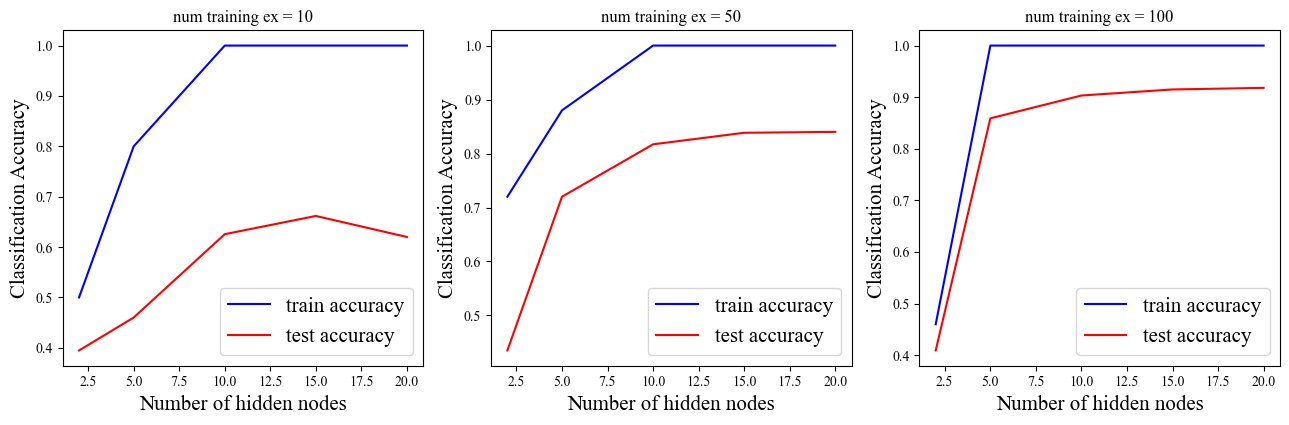

In [11]:
# compute comparative multiclass classification metrics on test data

M_list = [2, 5, 10, 15, 20]
list_digits=['0','1','2','3','4']

# Data preprocessing

X_train, X_test, y_train, y_test = sample_multiclass_MNIST(list_digits=list_digits, full_MNIST=[X,y])

## Train
train_size_list = [10, 50, 100]

# make plot
ncols = len(train_size_list)
fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=[13,5])

for t in np.arange(len(train_size_list)):
    accuracy_list_test = []
    accuracy_list_train = []
    
    train_size = train_size_list[t]
    idx = np.random.choice(np.arange(len(y_train)), train_size)
    X_train0 = X_train[idx, :]/np.max(X_train)
    y_train0 = y_train[idx, :]

    out = []
    out_train = []
    # populate the tuple list with the data
    for i in range(X_train0.shape[0]):
        item = list((X_train0[i,:].tolist(), y_train0[i,:].tolist())) 
        out.append(item)
        out_train.append(X_train0[i,:].tolist())

    X_test /= np.max(X_test)
    out_test = []
    for i in range(X_test.shape[0]):
        out_test.append(X_test[i,:].tolist())

    for M in M_list:

        # FFNN training
        NN = DeepFFNN(hidden_layer_sizes=[M], training_data = out)
        NN.train(iterations=100, learning_rate = 0.5, momentum = 0, rate_decay = 0.01)
        
        # FFNN prediction
        print()
        y_hat_train = NN.predict(out_train, normalize=True)
        y_hat_test = NN.predict(out_test, normalize=True)

        y_train_label = np.asarray(onehot2list(y_train0))
        y_test_label = np.asarray(onehot2list(y_test))

        results_train = multiclass_accuracy_metrics(Y_test=y_train0, P_pred=y_hat_train.T)
        results_test = multiclass_accuracy_metrics(Y_test=y_test, P_pred=y_hat_test.T)

        accuracy_list_train.append(results_train.get('Accuracy'))
        accuracy_list_test.append(results_test.get('Accuracy'))
    
    ## Plot
    ax[t].plot(M_list, accuracy_list_train, color='blue', label="train accuracy")
    ax[t].plot(M_list, accuracy_list_test, color='red', label="test accuracy")
    ax[t].set_xlabel('Number of hidden nodes', fontsize=15)
    ax[t].set_ylabel('Classification Accuracy', fontsize=15)
    ax[t].title.set_text("num training ex = %i" % (train_size)) 
    ax[t].legend(fontsize=15)
            
plt.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.savefig('MNIST_FFNN_accuracy_ex1.pdf')

In [ ]:
import random
import numpy as np

class MLP(object):
    """
    Multilayer Perceptron (2-layer Feedforward Neural Network) implementation 
    Input data type: training_data = [pattern1, pattern2, ..., pattern n]
    Activation: tanh for hidden layer and sigmoid for output layer 
    This 2-layer version should be easier to see what's going on than the deep FFNN code. 
    
    pattern i = [np.array (input), np.array (output)]
    
    """
    def __init__(self, 
                 hidden,
                 training_data):
       
        # initialize training data
        self.training_data = training_data
        
        # initialize layer sizes
        self.input = len(training_data[0][0]) + 1 # add 1 for bias node
        self.hidden = hidden
        self.output = len(training_data[0][1])

        # set up array of 1s for activations (node states)
        self.ai = np.ones(self.input)
        self.ah = np.ones(self.hidden)
        self.ao = np.ones(self.output)

        # create randomized weights
        # use scheme from 'efficient backprop to initialize weights'
        input_range = 1.0 / self.input ** (1/2)
        output_range = 1.0 / self.hidden ** (1/2)
        self.wi = np.random.normal(loc = 0, scale = input_range, size = (self.input, self.hidden))
        self.wo = np.random.normal(loc = 0, scale = output_range, size = (self.hidden, self.output))
        
        # create arrays of 0's to store previous gradients for momentum term in SGD update 
        self.ci = np.zeros((self.input, self.hidden))
        self.co = np.zeros((self.hidden, self.output))

    def feedForward(self, inputs):    
        # input activations
        self.ai[:-1] = inputs # -1 is to avoid the bias 
        # hidden activations
        self.ah = tanh(self.ai.T @ self.wi).T # hidden states 
        # output activations
        self.ao = sigmoid(self.ah.T @ self.wo).T # output states 
        
        return self.ao

    def backPropagate(self, targets):
        """
        Backpropagate errors from the output to the input layer 
        Return gradients for the weight matrices
        """

        # calculate error terms for output
        error = -(np.asarray(targets) - np.asarray(self.ao))
        output_deltas = dsigmoid(np.asarray(self.ao)) * error
        output_deltas.tolist()
        
        # calculate error terms for hidden
        error = self.wo @ output_deltas.reshape(-1,1)
        hidden_deltas = dtanh(self.ah.reshape(-1,1)) * error
        hidden_deltas = hidden_deltas[:,0]
            
        # compute gradients 
        grad1 = self.ah.reshape(-1,1) @ output_deltas.reshape(1,-1) 
        grad0 = self.ai.reshape(-1,1) @ hidden_deltas.reshape(1,-1) 
        
        return grad0, grad1

    def test(self, patterns):
        """
        Currently this will print out the targets next to the predictions.
        Not useful for actual ML, just for visual inspection.
        """
        for p in patterns:
            print(p[1], '->', self.feedForward(p[0]))

    def train(self, iterations=100, learning_rate=0.5, momentum=0.5, rate_decay=0.01):
        # N: learning rate
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.rate_decay = rate_decay
        error = 10
        i=0
        while (i<iterations) and (error>0.001):
            error = 0.0
            random.shuffle(self.training_data)
            for p in self.training_data:
                inputs = p[0]
                targets = p[1]
                self.feedForward(inputs)
                grad0, grad1 =self.backPropagate(targets)
            
                # update the weights connecting hidden to output
                self.wo -= self.learning_rate * grad1 + self.momentum * self.co
                self.co = grad1 # store current gradient 

                # update the weights connecting input to hidden
                self.wi -= self.learning_rate * grad0 + self.momentum * self.ci
                self.ci = grad0 # store current gradient 
        
                error += (0.5) * np.linalg.norm(np.asarray(targets) - self.ao)**2
            
            with open('error.txt', 'a') as errorfile:
                errorfile.write(str(error) + '\n')
                errorfile.close()
                
            if i % 5 == 0:
                print('iteration %i, error %-.5f' % (i, error))
            # learning rate decay
            self.learning_rate = 1/(np.log(i+2) * (i+50)**(0.5))
            # self.learning_rate = self.learning_rate * (self.learning_rate / (self.learning_rate + (self.learning_rate * self.rate_decay)))
            
            i += 1    
        
    
    def predict(self, X, normalize = False):
        X = np.asarray(X).T
        x = np.vstack((np.asarray(X), np.ones(X.shape[1]))) # add 1 for hidden units in the input layer
       
        W0 = self.wi
        W1 = self.wo 
        z = tanh(x.T @ W0).T # hidden states 
        y_hat = sigmoid((z.T @ W1).T) # output states
        
        if normalize:
            sum_of_cols = y_hat.sum(axis=0)
            y_hat /= sum_of_cols[np.newaxis,:]
        
        return y_hat
    
### Helper functions     
    
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# derivative of sigmoid
def dsigmoid(y):
    return y * (1.0 - y)

# using tanh over logistic sigmoid is recommended   

def tanh(x):
    return (1-np.exp(-2*x))/(1+np.exp(-2*x))
    # return np.tanh(x)
    
# derivative for tanh sigmoid
def dtanh(y):
    return 1 - y*y

## Classifying non-aligned MNIST images 

In [16]:
def random_padding(img, thickness=1):
    # img = a x b image 
    [a,b] = img.shape
    Y = np.zeros(shape=[a+thickness, b+thickness])
    r_loc = np.random.choice(np.arange(thickness+1))
    c_loc = np.random.choice(np.arange(thickness+1))
    Y[r_loc:r_loc+a, c_loc:c_loc+b] = img
    return Y

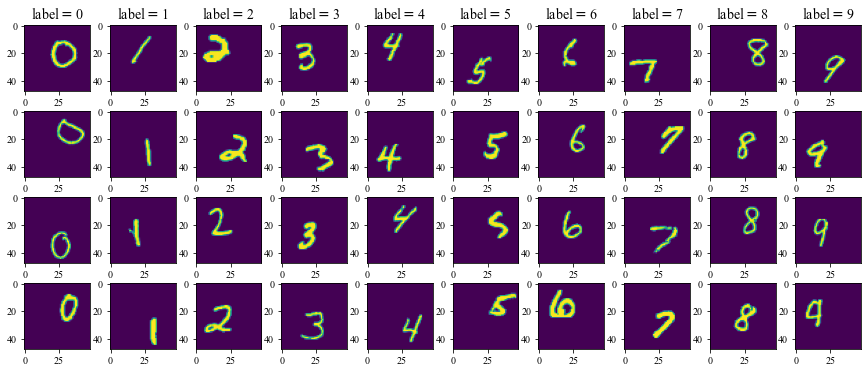

In [17]:
# Load MNIST images 
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
# X = X.values  ### Uncomment this line if you are having type errors in plotting. It is loading as a pandas dataframe, but our indexing is for numpy array. 
X = X / 255.

# Plot some sample images 
ncols = 10
nrows = 4
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=[15, 6.5])
for j in np.arange(ncols):
    for i in np.arange(nrows):
        idx = np.where(y==str(j)) # index of all images of digit 'j'
        idx = np.asarray(idx)[0,:] # make idx from tuple to array
        idx_subsampled = np.random.choice(idx, nrows)
        img = X[idx_subsampled[i],:].reshape(28,28)
        img_padded = random_padding(img, thickness=20)
        ax[i,j].imshow(img_padded, cmap='viridis')
        # ax[i,j].title.set_text("label=%s" % y[idx_subsampled[j]]) 
        if i == 0:
            # ax[j,i].set_ylabel("label=%s" % y[idx_subsampled[j]]) 
            ax[i,j].set_title("label$=$%s" % y[idx_subsampled[i]], fontsize=14) 
        # ax[i].legend()
plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.savefig('MNIST_padded_ex1.pdf', bbox_inches='tight')

In [18]:
def sample_multiclass_MNIST_padding(list_digits=['0','1', '2'], full_MNIST=None, padding_thickness=10):
    # get train and test set from MNIST of given digits
    # e.g., list_digits = ['0', '1', '2']
    # pad each 28 x 28 image with zeros so that it has now "padding_thickness" more rows and columns
    # The original image is superimposed at a uniformly chosen location 
    if full_MNIST is not None:
        X, y = full_MNIST
    else:
        X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
        X = X / 255.
    Y = list2onehot(y.tolist(), list_digits)
    
    idx = [i for i in np.arange(len(y)) if y[i] in list_digits] # list of indices where the label y is in list_digits
    
    X01 = X[idx,:]
    y01 = Y[idx,:]

    X_train = []
    X_test = []
    y_test = [] # list of one-hot encodings (indicator vectors) of each label  
    y_train = [] # list of one-hot encodings (indicator vectors) of each label  

    for i in trange(X01.shape[0]):
        # for each example i, make it into train set with probabiliy 0.8 and into test set otherwise 
        U = np.random.rand() # Uniform([0,1]) variable
        img_padded = random_padding(X01[i,:].reshape(28,28), thickness=padding_thickness)
        img_padded_vec = img_padded.reshape(1,-1)
        if U<0.8:
            X_train.append(img_padded_vec[0,:].copy())
            y_train.append(y01[i,:].copy())
        else:
            X_test.append(img_padded_vec[0,:].copy())
            y_test.append(y01[i,:].copy())

    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)
    return X_train, X_test, y_train, y_test

In [ ]:
# Simple MNIST binary classification experiments 

X_train, X_test, y_train, y_test = sample_multiclass_MNIST_padding(list_digits=['0','1'], 
                                                                   full_MNIST=[X,y, ], 
                                                                   padding_thickness=10)
# data subsampling 
train_size = X_train.shape[0]

print('train_size', train_size)

idx = np.random.choice(np.arange(len(y_train)), train_size)
X_train0 = X_train[idx, :]/np.max(X_train)
y_train0 = y_train[idx, :]

# preprocessing 
out = []
# populate the tuple list with the data
for i in range(X_train0.shape[0]):
    item = list((X_train0[i,:], y_train0[i,:])) # don't mind this variable name
    out.append(item)

# FFNN training
NN = DeepFFNN(hidden_layer_sizes=[10], training_data = out)
NN.train(iterations=100, learning_rate = 0.5, momentum = 0, rate_decay = 0.01)

#NN = MLP_NeuralNetwork_fast(hidden=M, training_data = out)
#NN.train(iterations=100, learning_rate = 0.5, momentum = 0, rate_decay = 0.01)

# FFNN prediction

X_test /= np.max(X_test)
out_test = []
for i in range(X_test.shape[0]):
    out_test.append(X_test[i,:].tolist())

y_hat = NN.predict(out_test).T
y_test_label = np.asarray(onehot2list(y_test))
P_pred = np.asarray([p[1] for p in y_hat])

compute_accuracy_metrics(Y_test=y_test_label, P_pred=P_pred, use_opt_threshold=False, verbose=True)

100%|██████████| 14780/14780 [00:00<00:00, 58396.51it/s]


weight_matrix.shape (785, 10)
weight_matrix.shape (10, 2)
iteration 0, error 1.61689
iteration 5, error 0.05916
iteration 10, error 0.04500
iteration 15, error 0.03786
iteration 20, error 0.03331
iteration 25, error 0.03007
iteration 30, error 0.02762
iteration 35, error 0.02567
iteration 40, error 0.02409
iteration 45, error 0.02276
iteration 50, error 0.02163
iteration 55, error 0.02065
iteration 60, error 0.01979
iteration 65, error 0.01903
iteration 70, error 0.01836
iteration 75, error 0.01775
iteration 80, error 0.01720
iteration 85, error 0.01670
iteration 90, error 0.01624
iteration 95, error 0.01581

X.shape (784, 50)
y_hat.shape (2, 50)
X.shape (784, 2930)
y_hat.shape (2, 2930)
!!! confusion_mx [[28  0]
 [ 0 22]]
!!! Accuracy 1.0
!!! confusion_mx [[1382   11]
 [   3 1534]]
!!! Accuracy 0.995221843003413


100%|██████████| 14780/14780 [00:00<00:00, 53986.11it/s]


weight_matrix.shape (1090, 10)
weight_matrix.shape (10, 2)
iteration 0, error 6.69707
iteration 5, error 0.14262
iteration 10, error 0.09201
iteration 15, error 0.07172
iteration 20, error 0.06015
iteration 25, error 0.05250
iteration 30, error 0.04700
iteration 35, error 0.04281
iteration 40, error 0.03951
iteration 45, error 0.03681
iteration 50, error 0.03457
iteration 55, error 0.03267
iteration 60, error 0.03103
iteration 65, error 0.02961
iteration 70, error 0.02835
iteration 75, error 0.02724
iteration 80, error 0.02624
iteration 85, error 0.02534
iteration 90, error 0.02452
iteration 95, error 0.02377

X.shape (1089, 50)
y_hat.shape (2, 50)
X.shape (1089, 3021)
y_hat.shape (2, 3021)
!!! confusion_mx [[27  0]
 [ 0 23]]
!!! Accuracy 1.0
!!! confusion_mx [[1299  120]
 [ 126 1476]]
!!! Accuracy 0.9185700099304865


100%|██████████| 14780/14780 [00:00<00:00, 53771.45it/s]


weight_matrix.shape (1445, 10)
weight_matrix.shape (10, 2)
iteration 0, error 12.10286
iteration 5, error 2.14518
iteration 10, error 1.39493
iteration 15, error 1.22948
iteration 20, error 1.15916
iteration 25, error 1.11601
iteration 30, error 1.08434
iteration 35, error 1.05689
iteration 40, error 1.02471
iteration 45, error 0.96830
iteration 50, error 0.75831
iteration 55, error 0.48241
iteration 60, error 0.38418
iteration 65, error 0.32611
iteration 70, error 0.28533
iteration 75, error 0.25452
iteration 80, error 0.23008
iteration 85, error 0.21024
iteration 90, error 0.19371
iteration 95, error 0.17969

X.shape (1444, 50)
y_hat.shape (2, 50)
X.shape (1444, 2993)
y_hat.shape (2, 2993)
!!! confusion_mx [[22  0]
 [ 0 28]]
!!! Accuracy 1.0
!!! confusion_mx [[ 856  517]
 [ 318 1302]]
!!! Accuracy 0.721015703307718


100%|██████████| 14780/14780 [00:00<00:00, 50777.50it/s]


weight_matrix.shape (1850, 10)
weight_matrix.shape (10, 2)
iteration 0, error 11.56514
iteration 5, error 3.27257
iteration 10, error 2.03309
iteration 15, error 1.19695
iteration 20, error 0.76122
iteration 25, error 0.53362
iteration 30, error 0.40031
iteration 35, error 0.31807
iteration 40, error 0.26473
iteration 45, error 0.22730
iteration 50, error 0.19965
iteration 55, error 0.17836
iteration 60, error 0.16152
iteration 65, error 0.14785
iteration 70, error 0.13651
iteration 75, error 0.12698
iteration 80, error 0.11886
iteration 85, error 0.11184
iteration 90, error 0.10571
iteration 95, error 0.10033

X.shape (1849, 50)
y_hat.shape (2, 50)
X.shape (1849, 2934)
y_hat.shape (2, 2934)
!!! confusion_mx [[25  0]
 [ 0 25]]
!!! Accuracy 1.0
!!! confusion_mx [[ 939  441]
 [ 546 1008]]
!!! Accuracy 0.66359918200409


100%|██████████| 14780/14780 [00:00<00:00, 46683.22it/s]


weight_matrix.shape (2305, 10)
weight_matrix.shape (10, 2)
iteration 0, error 14.08749
iteration 5, error 2.48330
iteration 10, error 0.78764
iteration 15, error 0.44002
iteration 20, error 0.30957
iteration 25, error 0.24096
iteration 30, error 0.19850
iteration 35, error 0.16961
iteration 40, error 0.14867
iteration 45, error 0.13279
iteration 50, error 0.12031
iteration 55, error 0.11024
iteration 60, error 0.10194
iteration 65, error 0.09500
iteration 70, error 0.08908
iteration 75, error 0.08399
iteration 80, error 0.07956
iteration 85, error 0.07566
iteration 90, error 0.07221
iteration 95, error 0.06913

X.shape (2304, 50)
y_hat.shape (2, 50)
X.shape (2304, 2901)
y_hat.shape (2, 2901)
!!! confusion_mx [[24  0]
 [ 0 26]]
!!! Accuracy 1.0
!!! confusion_mx [[1027  345]
 [ 806  723]]
!!! Accuracy 0.603240261978628


100%|██████████| 14780/14780 [00:00<00:00, 63326.61it/s]


weight_matrix.shape (785, 10)
weight_matrix.shape (10, 2)
iteration 0, error 1.91902
iteration 5, error 0.05373
iteration 10, error 0.04190
iteration 15, error 0.03574
iteration 20, error 0.03174
iteration 25, error 0.02886
iteration 30, error 0.02665
iteration 35, error 0.02488
iteration 40, error 0.02343
iteration 45, error 0.02221
iteration 50, error 0.02116
iteration 55, error 0.02026
iteration 60, error 0.01946
iteration 65, error 0.01875
iteration 70, error 0.01811
iteration 75, error 0.01754
iteration 80, error 0.01702
iteration 85, error 0.01655
iteration 90, error 0.01611
iteration 95, error 0.01571

X.shape (784, 100)
y_hat.shape (2, 100)
X.shape (784, 2959)
y_hat.shape (2, 2959)
!!! confusion_mx [[47  0]
 [ 0 53]]
!!! Accuracy 1.0
!!! confusion_mx [[1381    2]
 [   9 1567]]
!!! Accuracy 0.9962825278810409


100%|██████████| 14780/14780 [00:00<00:00, 58133.17it/s]


weight_matrix.shape (1090, 10)
weight_matrix.shape (10, 2)
iteration 0, error 14.31530
iteration 5, error 0.58969
iteration 10, error 0.25675
iteration 15, error 0.16192
iteration 20, error 0.12023
iteration 25, error 0.09749
iteration 30, error 0.08318
iteration 35, error 0.07323
iteration 40, error 0.06586
iteration 45, error 0.06012
iteration 50, error 0.05550
iteration 55, error 0.05170
iteration 60, error 0.04850
iteration 65, error 0.04576
iteration 70, error 0.04339
iteration 75, error 0.04130
iteration 80, error 0.03946
iteration 85, error 0.03781
iteration 90, error 0.03633
iteration 95, error 0.03500

X.shape (1089, 100)
y_hat.shape (2, 100)
X.shape (1089, 2957)
y_hat.shape (2, 2957)
!!! confusion_mx [[51  0]
 [ 0 49]]
!!! Accuracy 1.0
!!! confusion_mx [[1332   38]
 [  88 1499]]
!!! Accuracy 0.9573892458572878


100%|██████████| 14780/14780 [00:00<00:00, 56722.10it/s]


weight_matrix.shape (1445, 10)
weight_matrix.shape (10, 2)
iteration 0, error 22.18739
iteration 5, error 2.45142
iteration 10, error 0.74909
iteration 15, error 0.45005
iteration 20, error 0.32462
iteration 25, error 0.25529
iteration 30, error 0.21268
iteration 35, error 0.18366
iteration 40, error 0.16255
iteration 45, error 0.14645
iteration 50, error 0.13371
iteration 55, error 0.12338
iteration 60, error 0.11483
iteration 65, error 0.10760
iteration 70, error 0.10142
iteration 75, error 0.09605
iteration 80, error 0.09135
iteration 85, error 0.08720
iteration 90, error 0.08349
iteration 95, error 0.08017

X.shape (1444, 100)
y_hat.shape (2, 100)
X.shape (1444, 3019)
y_hat.shape (2, 3019)
!!! confusion_mx [[49  0]
 [ 0 51]]
!!! Accuracy 1.0
!!! confusion_mx [[1234  205]
 [ 246 1334]]
!!! Accuracy 0.850612785690626


100%|██████████| 14780/14780 [00:00<00:00, 53710.70it/s]


weight_matrix.shape (1850, 10)
weight_matrix.shape (10, 2)
iteration 0, error 26.33830
iteration 5, error 2.61895
iteration 10, error 0.79535
iteration 15, error 0.46952
iteration 20, error 0.33410
iteration 25, error 0.26460
iteration 30, error 0.22089
iteration 35, error 0.19125
iteration 40, error 0.16947
iteration 45, error 0.15280
iteration 50, error 0.13960
iteration 55, error 0.12882
iteration 60, error 0.11991
iteration 65, error 0.11236
iteration 70, error 0.10588
iteration 75, error 0.10026
iteration 80, error 0.09533
iteration 85, error 0.09097
iteration 90, error 0.08709
iteration 95, error 0.08360

X.shape (1849, 100)
y_hat.shape (2, 100)
X.shape (1849, 2994)
y_hat.shape (2, 2994)
!!! confusion_mx [[48  0]
 [ 0 52]]
!!! Accuracy 1.0
!!! confusion_mx [[1066  308]
 [ 562 1058]]
!!! Accuracy 0.7094188376753507


100%|██████████| 14780/14780 [00:00<00:00, 47839.76it/s]


weight_matrix.shape (2305, 10)
weight_matrix.shape (10, 2)
iteration 0, error 25.71883
iteration 5, error 6.62066
iteration 10, error 1.92367
iteration 15, error 0.98810
iteration 20, error 0.69555
iteration 25, error 0.54175
iteration 30, error 0.42637
iteration 35, error 0.33088
iteration 40, error 0.27991
iteration 45, error 0.24555
iteration 50, error 0.22039
iteration 55, error 0.20084
iteration 60, error 0.18514
iteration 65, error 0.17224
iteration 70, error 0.16139
iteration 75, error 0.15212
iteration 80, error 0.14413
iteration 85, error 0.13712
iteration 90, error 0.13093
iteration 95, error 0.12541

X.shape (2304, 100)
y_hat.shape (2, 100)
X.shape (2304, 2916)
y_hat.shape (2, 2916)
!!! confusion_mx [[49  0]
 [ 0 51]]
!!! Accuracy 1.0
!!! confusion_mx [[ 804  543]
 [ 568 1001]]
!!! Accuracy 0.6189986282578875


100%|██████████| 14780/14780 [00:00<00:00, 64035.97it/s]


weight_matrix.shape (785, 10)
weight_matrix.shape (10, 2)
iteration 0, error 3.48994
iteration 5, error 0.37558
iteration 10, error 0.13631
iteration 15, error 0.09078
iteration 20, error 0.06635
iteration 25, error 0.05309
iteration 30, error 0.04492
iteration 35, error 0.03933
iteration 40, error 0.03526
iteration 45, error 0.03215
iteration 50, error 0.02970
iteration 55, error 0.02771
iteration 60, error 0.02606
iteration 65, error 0.02467
iteration 70, error 0.02347
iteration 75, error 0.02243
iteration 80, error 0.02152
iteration 85, error 0.02071
iteration 90, error 0.01998
iteration 95, error 0.01933

X.shape (784, 200)
y_hat.shape (2, 200)
X.shape (784, 2967)
y_hat.shape (2, 2967)
!!! confusion_mx [[101   0]
 [  0  99]]
!!! Accuracy 1.0
!!! confusion_mx [[1385    1]
 [   8 1573]]
!!! Accuracy 0.9969666329625885


100%|██████████| 14780/14780 [00:00<00:00, 58094.98it/s]


weight_matrix.shape (1090, 10)
weight_matrix.shape (10, 2)
iteration 0, error 14.74621
iteration 5, error 1.35728
iteration 10, error 1.13870
iteration 15, error 1.06063
iteration 20, error 1.00900
iteration 25, error 0.96628
iteration 30, error 0.92866
iteration 35, error 0.89315
iteration 40, error 0.86005
iteration 45, error 0.82885
iteration 50, error 0.79859
iteration 55, error 0.76690
iteration 60, error 0.73203
iteration 65, error 0.69553
iteration 70, error 0.66252
iteration 75, error 0.63412
iteration 80, error 0.60793
iteration 85, error 0.58088
iteration 90, error 0.54891
iteration 95, error 0.50728

X.shape (1089, 200)
y_hat.shape (2, 200)
X.shape (1089, 2948)
y_hat.shape (2, 2948)
!!! confusion_mx [[ 82   0]
 [  1 117]]
!!! Accuracy 0.995



  0%|          | 0/14780 [00:00<?, ?it/s]

!!! confusion_mx [[1328   73]
 [  45 1502]]
!!! Accuracy 0.9599728629579376


100%|██████████| 14780/14780 [00:00<00:00, 48583.31it/s]


weight_matrix.shape (1445, 10)
weight_matrix.shape (10, 2)
iteration 0, error 41.77516
iteration 5, error 3.07951
iteration 10, error 1.31271
iteration 15, error 0.89762
iteration 20, error 0.70526
iteration 25, error 0.59010
iteration 30, error 0.51227
iteration 35, error 0.45571
iteration 40, error 0.41263
iteration 45, error 0.37849
iteration 50, error 0.35073
iteration 55, error 0.32763
iteration 60, error 0.30809
iteration 65, error 0.29130
iteration 70, error 0.27671
iteration 75, error 0.26389
iteration 80, error 0.25253
iteration 85, error 0.24238
iteration 90, error 0.23324
iteration 95, error 0.22498

X.shape (1444, 200)
y_hat.shape (2, 200)
X.shape (1444, 2927)
y_hat.shape (2, 2927)
!!! confusion_mx [[ 90   0]
 [  0 110]]
!!! Accuracy 1.0



  0%|          | 0/14780 [00:00<?, ?it/s]

!!! confusion_mx [[1277   80]
 [  64 1506]]
!!! Accuracy 0.9508028698325931


100%|██████████| 14780/14780 [00:00<00:00, 51266.97it/s]


weight_matrix.shape (1850, 10)
weight_matrix.shape (10, 2)
iteration 0, error 46.47227
iteration 5, error 5.28568
iteration 10, error 3.38963
iteration 15, error 2.39391
iteration 20, error 1.88188
iteration 25, error 1.54219
iteration 30, error 1.23664
iteration 35, error 0.92538
iteration 40, error 0.70700
iteration 45, error 0.57768
iteration 50, error 0.49947
iteration 55, error 0.44717
iteration 60, error 0.40859
iteration 65, error 0.37848
iteration 70, error 0.35392
iteration 75, error 0.33342
iteration 80, error 0.31596
iteration 85, error 0.30087
iteration 90, error 0.28767
iteration 95, error 0.27600

X.shape (1849, 200)
y_hat.shape (2, 200)
X.shape (1849, 3070)
y_hat.shape (2, 3070)
!!! confusion_mx [[ 96   0]
 [  0 104]]
!!! Accuracy 1.0
!!! confusion_mx [[1283  208]
 [ 144 1435]]
!!! Accuracy 0.885342019543974


100%|██████████| 14780/14780 [00:00<00:00, 48487.96it/s]


weight_matrix.shape (2305, 10)
weight_matrix.shape (10, 2)
iteration 0, error 49.99138
iteration 5, error 7.69842
iteration 10, error 2.80500
iteration 15, error 1.54758
iteration 20, error 0.89355
iteration 25, error 0.67680
iteration 30, error 0.55270
iteration 35, error 0.47223
iteration 40, error 0.41472
iteration 45, error 0.37156
iteration 50, error 0.33783
iteration 55, error 0.31072
iteration 60, error 0.28845
iteration 65, error 0.26970
iteration 70, error 0.25380
iteration 75, error 0.24002
iteration 80, error 0.22802
iteration 85, error 0.21744
iteration 90, error 0.20802
iteration 95, error 0.19959

X.shape (2304, 200)
y_hat.shape (2, 200)
X.shape (2304, 2885)
y_hat.shape (2, 2885)
!!! confusion_mx [[104   0]
 [  0  96]]
!!! Accuracy 1.0
!!! confusion_mx [[1123  231]
 [ 283 1248]]
!!! Accuracy 0.8218370883882149


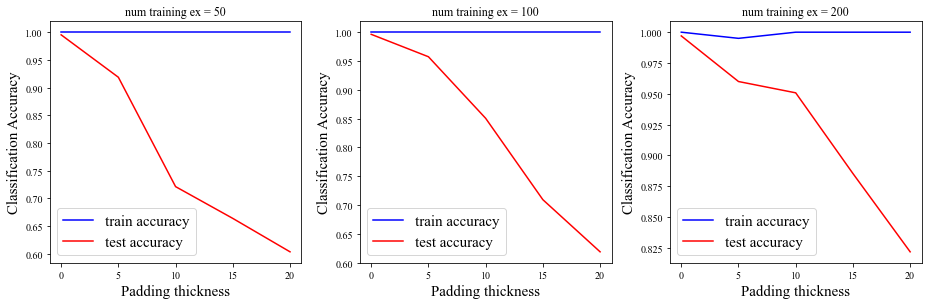

In [ ]:
# compute comparative multiclass classification metrics on test data

padding_list = [0, 5, 10, 15, 20]
list_digits=['0','1','2','3','4']
# list_digits=['0','1']

## Train
train_size_list = [50, 100, 200]

# make plot
ncols = len(train_size_list)
fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=[13,5])

for t in np.arange(len(train_size_list)):
    accuracy_list_test = []
    accuracy_list_train = []
    
    for thickness in padding_list:
        # Data preprocessing
        X_train, X_test, y_train, y_test = sample_multiclass_MNIST_padding(list_digits=list_digits, 
                                                                           full_MNIST=[X,y], 
                                                                           padding_thickness=thickness)
            
        train_size = train_size_list[t]
        idx = np.random.choice(np.arange(len(y_train)), train_size)
        X_train0 = X_train[idx, :]/np.max(X_train)
        y_train0 = y_train[idx, :]

        out = []
        out_train = []
        # populate the tuple list with the data
        for i in range(X_train0.shape[0]):
            item = list((X_train0[i,:].tolist(), y_train0[i,:].tolist())) # don't mind this variable name
            out.append(item)
            out_train.append(X_train0[i,:].tolist())

        X_test /= np.max(X_test)
        out_test = []
        for i in range(X_test.shape[0]):
            out_test.append(X_test[i,:].tolist())    

        # FFNN training
        NN = DeepFFNN(hidden_layer_sizes=[10], training_data = out)
        NN.train(iterations=100, learning_rate = 0.5, momentum = 0, rate_decay = 0.01)
        
        # FFNN prediction
        print()
        y_hat_train = NN.predict(out_train, normalize=True)
        y_hat_test = NN.predict(out_test, normalize=True)

        y_train_label = np.asarray(onehot2list(y_train0))
        y_test_label = np.asarray(onehot2list(y_test))

        results_train = multiclass_accuracy_metrics(Y_test=y_train0, P_pred=y_hat_train.T)
        results_test = multiclass_accuracy_metrics(Y_test=y_test, P_pred=y_hat_test.T)

        accuracy_list_train.append(results_train.get('Accuracy'))
        accuracy_list_test.append(results_test.get('Accuracy'))
    
    ## Plot
    ax[t].plot(padding_list, accuracy_list_train, color='blue', label="train accuracy")
    ax[t].plot(padding_list, accuracy_list_test, color='red', label="test accuracy")
    ax[t].set_xlabel('Padding thickness', fontsize=15)
    ax[t].set_ylabel('Classification Accuracy', fontsize=15)
    ax[t].title.set_text("num training ex = %i" % (train_size)) 
    ax[t].legend(fontsize=15)
            
plt.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.savefig('MNIST_FFNN_accuracy_padding_ex3.pdf')